## Initialize

In [1]:
getwd()

[1] "/home/steinfej/code/22_medical_records/2_figures"

In [2]:
#library(Rmisc)
library(tidyverse)
library(glue)
library(arrow)
library(patchwork)
library(data.table)

Warning message:
“package ‘tidyverse’ was built under R version 4.0.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Warning message:
“package ‘readr’ was built under R version 4.0.5”
Warning message:
“package ‘purrr’ was built under R version 4.0.3”
Warning message:
“package ‘dplyr’ was built under R version 4.0.5”
Warning message:
“package ‘stringr’ was built under R version 4.0.5”
Warning message:
“package ‘forcats’ was built under R version 4.0.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘arrow’ was built under R version 4.0.3”

Attaching package: ‘arrow’


The following object is masked from ‘p

In [3]:
if (grepl("sc", Sys.info()[["nodename"]], fixed=TRUE)) {
    base_path = "/sc-projects/sc-proj-ukb-cvd"
} else {
    base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"}
print(base_path)

project_label="22_medical_records"
project_path = glue("{base_path}/results/projects/{project_label}")
figure_path = glue("{project_path}/figures")
output_path = glue("{project_path}/data")

experiment = 220413
experiment_path = glue("{output_path}/{experiment}")

[1] "/sc-projects/sc-proj-ukb-cvd"


## Load data

In [4]:
endpoints_md = fread(glue("{experiment_path}/endpoints.csv"))
endpoints = sort(endpoints_md$endpoint)
detach("package:data.table", unload=TRUE)

In [5]:
endpoint_selection = c(
    "phecode_008",
    "phecode_092-2",
    "phecode_105",
    "phecode_107-2",
    "phecode_164",
    "phecode_202-2",
    "phecode_284",
    "phecode_292",
    "phecode_324-11",
    "phecode_328",
    "phecode_371",
    "phecode_401",
    "phecode_404",
    "phecode_424",
    "phecode_440-11",
    "phecode_468",
    "phecode_474",
    "phecode_522-1",
    "phecode_542-1",
    "phecode_581-1",
    "phecode_583",
    "phecode_665",
    "phecode_705-1",
    "OMOP_4306655"  
    )

In [6]:
endpoint_defs = arrow::read_feather(glue("{output_path}/phecode_defs_220306.feather")) %>% arrange(endpoint)

In [7]:
endpoint_defs = endpoint_defs %>% 
    mutate(name = phecode_string) %>% 
    mutate(name = 
           case_when( 
               endpoint == "phecode_008"~"H. pylori", 
               endpoint == "phecode_092-2"~"Sepsis", 
               endpoint == "phecode_105"~"Breast cancer", 
                endpoint == "phecode_107-2"~"Prostate cancer", 
               endpoint == "phecode_123"~"Malignant plasma cell neoplasms", 
               endpoint == "phecode_164"~"Anemia", 
               endpoint == "phecode_200-1"~"Hypothyroidism", 
               endpoint == "phecode_232"~"Vitamin deficiencies", 
               endpoint == "phecode_284"~"Suicide attempt or self harm", 
               #endpoint == "phecode_287-5"~"Drug-induced psychosis", 
               endpoint == "phecode_324-11"~"Parkinson's",
               endpoint == "phecode_328"~"Dementia", 
               #endpoint == "phecode_404"~"Coronary heart disease", 
               endpoint == "phecode_424"~"Heart failure", 
               endpoint == "phecode_440-11"~"Deep vein thrombosis", 
               endpoint == "phecode_468"~"Pneumonia", 
               endpoint == "phecode_474"~"COPD", 
               endpoint == "phecode_518"~"Appendicitis", 
               endpoint == "phecode_542-1"~"Fibrosis and cirrhosis of liver", 
               endpoint == "phecode_583"~"Chronic kidney disease", 
               endpoint == "phecode_705-1"~"Rheumatoid arthritis", 
               endpoint == "phecode_908-1"~"(Pre)eclampsia", 
               #endpoint == "phecode_976"~"Complication of anesthesia",
               TRUE ~ name)
           )

endpoint_map = endpoint_defs$name
names(endpoint_map) =  endpoint_defs$endpoint
endpoint_order = (endpoint_defs %>% filter(endpoint %in% endpoint_selection) %>% arrange(as.numeric(phecode)))$endpoint

In [8]:
eligable_eids = arrow::read_feather(glue("{output_path}/eligable_eids_long_220414.feather")) %>% 
    filter(endpoint %in% endpoint_selection) %>% 
    mutate(endpoint = as.character(endpoint)) %>%
    mutate(eid = as.numeric(as.character(eid))) %>%
    mutate(included = 1)

Warning message:
“Coercing dictionary values to R character factor levels”


In [9]:
pred_path = "/sc-projects/sc-proj-ukb-cvd/results/projects/22_medical_records/data/220413/coxph/predictions"

In [10]:
partitions = 0:21

In [11]:
paths = c()
for (endpoint in endpoint_selection){
    for (feature in c("Age+Sex", "Age+Sex+MedicalHistory")){
        for (p in partitions){
            temp_path = glue("{experiment_path}/coxph/predictions/{endpoint}_{feature}_{p}.feather")
            paths = c(paths, temp_path)
            }
        }
    }

In [12]:
predictions = paths %>% map_df(
    ~suppressWarnings(read_feather(., col_select = c("eid", "endpoint", "features", "partition", "Ft_10"))) %>% 
    mutate(eid = as.integer(as.character(eid))) %>%
    select(endpoint, features, eid, partition, Ft_10))# %>% arrange(endpoint, eid)
predictions %>% head()

endpoint,features,eid,partition,Ft_10
<chr>,<chr>,<int>,<int>,<dbl>
phecode_008,Age+Sex,1475839,0,0.006214123
phecode_008,Age+Sex,1475840,0,0.005661233
phecode_008,Age+Sex,1475853,0,0.005777734
phecode_008,Age+Sex,1475862,0,0.005862496
phecode_008,Age+Sex,1475871,0,0.005721906
phecode_008,Age+Sex,1475886,0,0.005212695


In [13]:
data_outcomes = arrow::read_feather(glue("{output_path}/baseline_outcomes_long_220412.feather", as_data_frame=FALSE)) %>% 
    filter(endpoint %in% endpoint_selection) %>% left_join(eligable_eids, by=c("eid", "endpoint"))

In [14]:
predictions_tte = predictions %>% left_join(data_outcomes, by=c("endpoint", "eid"))

In [15]:
library("jsonlite")
colors_path = "colors.json"
colors_dict = read_json(colors_path)

color_map <- c(
     "Treat All" = "black",
    "Treat None" = "black",
    'Age+Sex' = colors_dict$pastel$grey$light, 
    'Age+Sex+MedicalHistory' = "forestgreen"
      )

type_map <- c('Age+Sex' = "solid", 
               'DS_Age+Sex+MedicalHistory' = "solid",#colors_dict$pastel$orange$mid,
              "Treat All" = "solid",
              "Treat None" = "solid"
      )

size_map <- c('Age+Sex' = 0.25, 
               'Age+Sex+MedicalHistory' = 0.25,
              "Treat All" = 0.25,
              "Treat None" = 0.25
      )

Warning message:
“package ‘jsonlite’ was built under R version 4.0.3”

Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




In [16]:
features_dca = c(
    "Age+Sex",
    "Age+Sex+MedicalHistory" 
              )

In [125]:
calculate_dca = function(endpoint){
   dca_temp = predictions_tte %>% 
    filter(endpoint==!!endpoint) %>%
    select(eid, features, Ft_10, event, time) %>% 
    filter(feature %in% features_dca) %>%
    pivot_wider(names_from="features", values_from="Ft_10") %>% 
    distinct()
    
    print(glue("{endpoint} n={nrow(dca_temp)}"))
    flush.console()

    prevalence = (dca_temp %>% 
        mutate(event_10 = case_when(event == 0 ~ 0, ((event==1)&(time>10)) ~ 0, ((event==1)&(time<=10)) ~ 1)) %>%
        summarise(prev = mean(event_10)))$prev
    thres_upper = min(prevalence*30, 1)
    
    dca_endpoint = dca(
        Surv(time, event) ~ `Age+Sex` + `Age+Sex+MedicalHistory`, 
        data = dca_temp,
        time = 10,
        thresholds = seq(0, thres_upper, by=thres_upper/500)
           )$dca
    return(dca_endpoint %>% mutate(st_net_benefit = net_benefit/prevalence))
}

In [126]:
library(foreach)
library(doParallel)

In [127]:
registerDoParallel(length(endpoint_order))

In [128]:
library(dcurves)
dca_data = foreach(key=endpoint_order, endpoint=endpoint_order) %dopar% {
    calculate_dca(endpoint)
}

In [129]:
names(dca_data) = endpoint_order
for (endpoint in endpoint_order){
    dca_data[[endpoint]]["endpoint"] = endpoint
    }

In [130]:
dca_data_agg = bind_rows(dca_data) 

In [84]:
base_size = 8
title_size = 10
facet_size = 10
geom_text_size=3
library(ggplot2); 
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major.y = element_line()))

## AgeSex + Metabolomics vs PANEL

In [46]:
endpoints_plot = endpoint_order

scores_plot = c(
    "Treat All", 
    "Treat None",
    "Age+Sex",
    "Age+Sex+MedicalHistory"
)

In [47]:
calibration_df = predictions_tte %>% 
    filter(endpoint %in% endpoints_plot) %>% 
    filter(feature %in% scores_plot) %>% 
    select(eid, endpoint, features, Ft_10, event, time) %>%
    group_by(endpoint, features) %>% mutate(risk_group = ntile(Ft_10, 10), 
                                         event_10 = case_when(event == 0 ~ 0,
                                                              ((event==1)&(time>10)) ~ 0,
                                                              ((event==1)&(time<=10)) ~ 1
                                                             )
                                        ) %>% 
    group_by(endpoint, features, risk_group) %>% 
    mutate(mean_risk = mean(Ft_10), mean_events = mean(event_10)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_plot))

In [49]:
library(lemon)

In [50]:
plots_cal = c()
for (endpoint in endpoints_plot){
    temp = calibration_df %>% filter(as.character(endpoint) == !!endpoint)
    endpoint_label = endpoint_map[[endpoint]]
    plots_cal[[endpoint]] = 
        ggplot(temp, aes(x=mean_risk*100, y=mean_events*100, color=features, size=features, linetype=features)) + 
        geom_abline(intercept=0, slope=1, color="#FA8334", alpha=1, size=0.5)+    
        #geom_point() + 
        geom_line(alpha=0.7)+
        labs(title=endpoint_label, x="Predicted Risk [%]", y="Observed Event Rate [%]") +
        scale_color_manual(values=color_map)+
        scale_linetype_manual(values=type_map)+
        scale_size_manual(values=size_map)+
        coord_cartesian(xlim=c(0, NA), ylim=c(0, NA))+
        theme(legend.position="none", axis.title = element_text())
    #print(plotsA[[endpoint]])
    flush.console()
    }

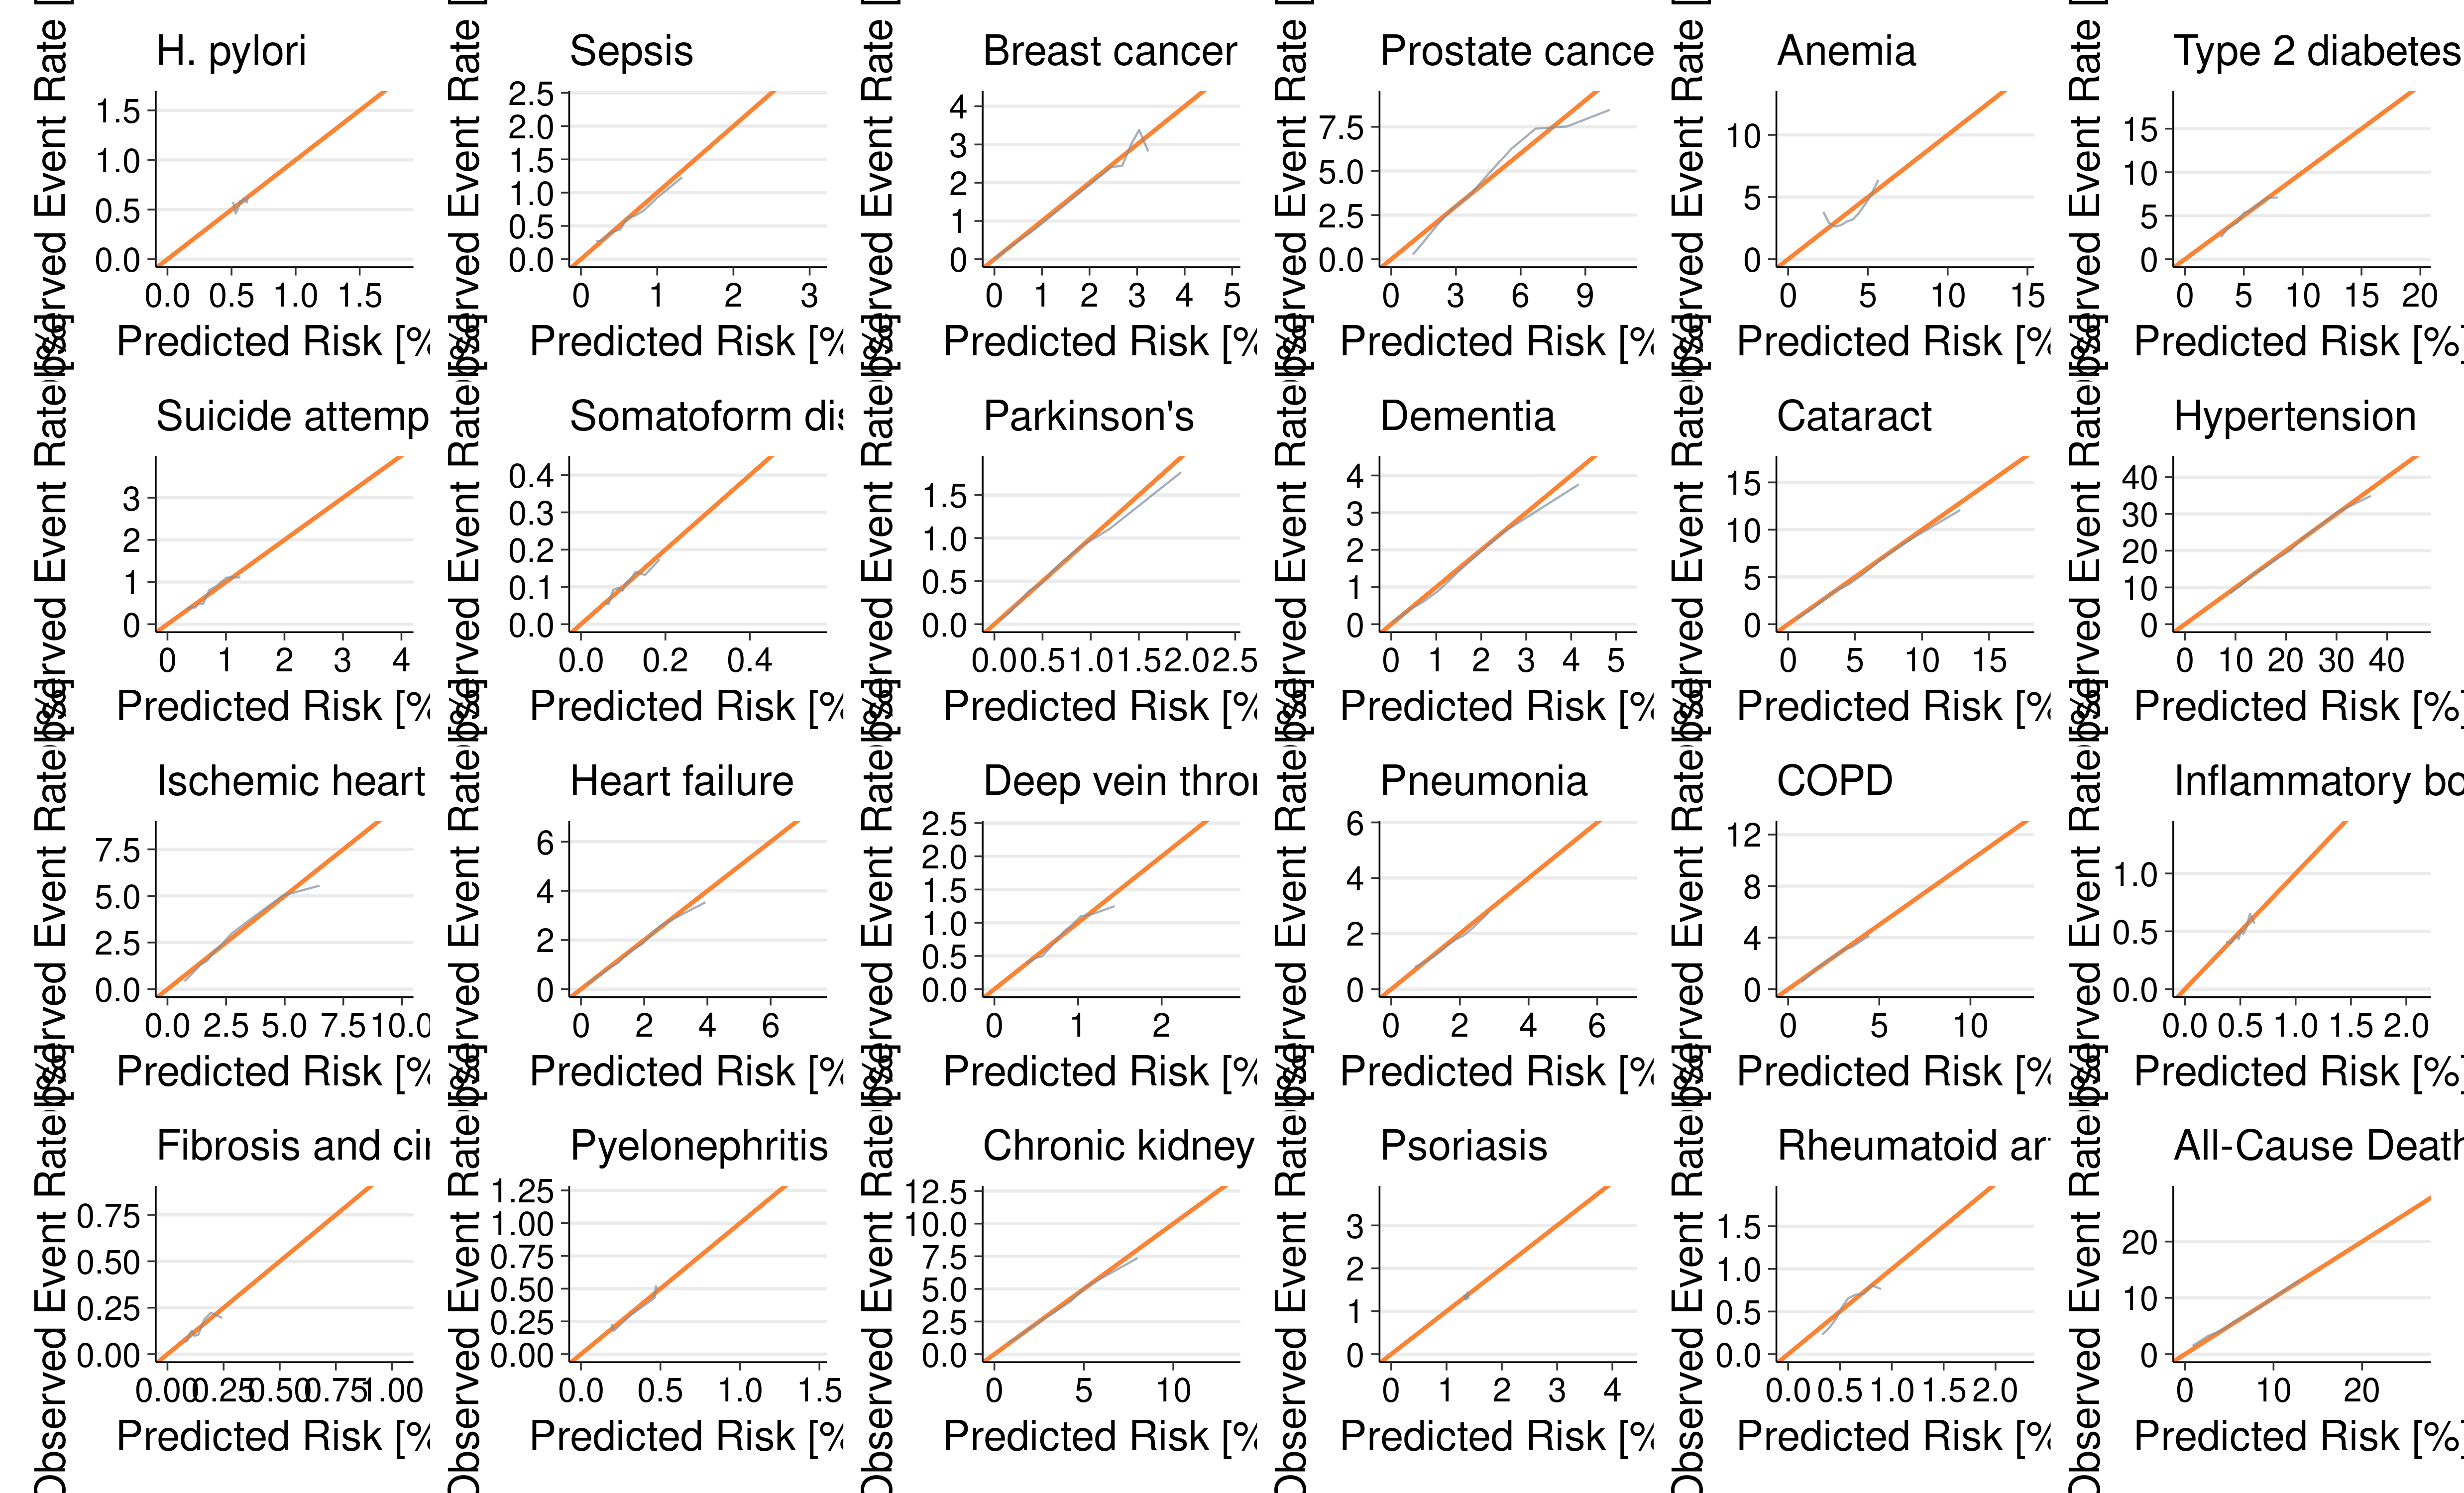

In [51]:
fig5_cal = wrap_plots(plots_cal, ncol=6)
plot_width=8.25; plot_height=5; plot_dpi=600
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_dpi)
fig5_cal

In [ ]:
met_map = c("High"="#023768", "Mid"="#4F8EC1", "Low"="#7AC6FF")

In [ ]:
dca_data

In [ ]:
plot_width=8.25; plot_height=5; plot_dpi=320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_dpi)

scores_plot = c(
    "Treat All", 
    "Treat None",
    "Age+Sex",
    "Age+Sex+MedicalHistory"
)

plotsA = c()
for (endpoint in endpoints_plot){
    temp = dca_data[[endpoint]] %>% 
        mutate(st_net_benefit = st_net_benefit*100, net_benefit=net_benefit*100) %>% 
        mutate(st_net_benefit = case_when((label == "Age+Sex")&is.na(st_net_benefit) ~ 0, TRUE ~ st_net_benefit),
              net_benefit = case_when((label == "Age+Sex")&is.na(net_benefit) ~ 0, TRUE ~ net_benefit))
    
    cutoff = max(temp$net_benefit, na.rm=TRUE)/250
    
    if (min((temp %>% filter(label=="Age+Sex+MedicalHistory"))$net_benefit, na.rm=TRUE)>cutoff){
        threshold_max = (temp %>% filter(label=="Age+Sex+MedicalHistory") %>% slice_min(net_benefit))$threshold
        }
    else{
        threshold_max = min((temp %>% filter(label=="Age+Sex+MedicalHistory") %>% filter(net_benefit<cutoff))$threshold, na.rm=TRUE)
        }
    
    endpoint_label = endpoint_map[[endpoint]]
        temp_plot = temp %>% filter(label %in% scores_plot)
    temp_plot_wide = temp_plot %>%  select(threshold, label, net_benefit) %>% pivot_wider(names_from="label", values_from="net_benefit")
    plotsA[[endpoint]] = 
        ggplot(temp_plot)+
          labs(title=endpoint_label, x="Threshold [%]", y="Net Benefit [%]")+
        geom_ribbon(data=temp_plot_wide, mapping=aes(x=threshold, ymin=`Age+Sex`, ymax=`Age+Sex+MedicalHistory`), fill=colors_dict$pastel$green$mid, alpha=0.5, colour = NA)+
        #geom_ribbon(data=temp_plot_wide, mapping=aes(x=threshold, ymin=`DS_Age+Sex+Metabolomics`, ymax=`DS_PANELnoblood+Metabolomics`), fill="#023768", alpha=0.5, colour = NA)+
        geom_line(data=temp_plot, mapping=aes(x=threshold, y=net_benefit, color=label, linetype=label, size=label)) +       
        coord_cartesian(xlim=c(0, threshold_max), ylim=c(0, max(temp$net_benefit, na.rm=TRUE)))+
          scale_x_continuous(labels = function(x){x*100})+#labels = scales::percent_format(accuracy=1))+
          scale_color_manual(values=color_map)+
          scale_linetype_manual(values=type_map)+
    scale_size_manual(values=size_map)+
        theme(legend.position="none")
    print(plotsA[[endpoint]])
    flush.console()
    }

In [131]:
base_size = 8
title_size = 10
facet_size = 10
geom_text_size=3
library(ggplot2); 
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major = element_line()))

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


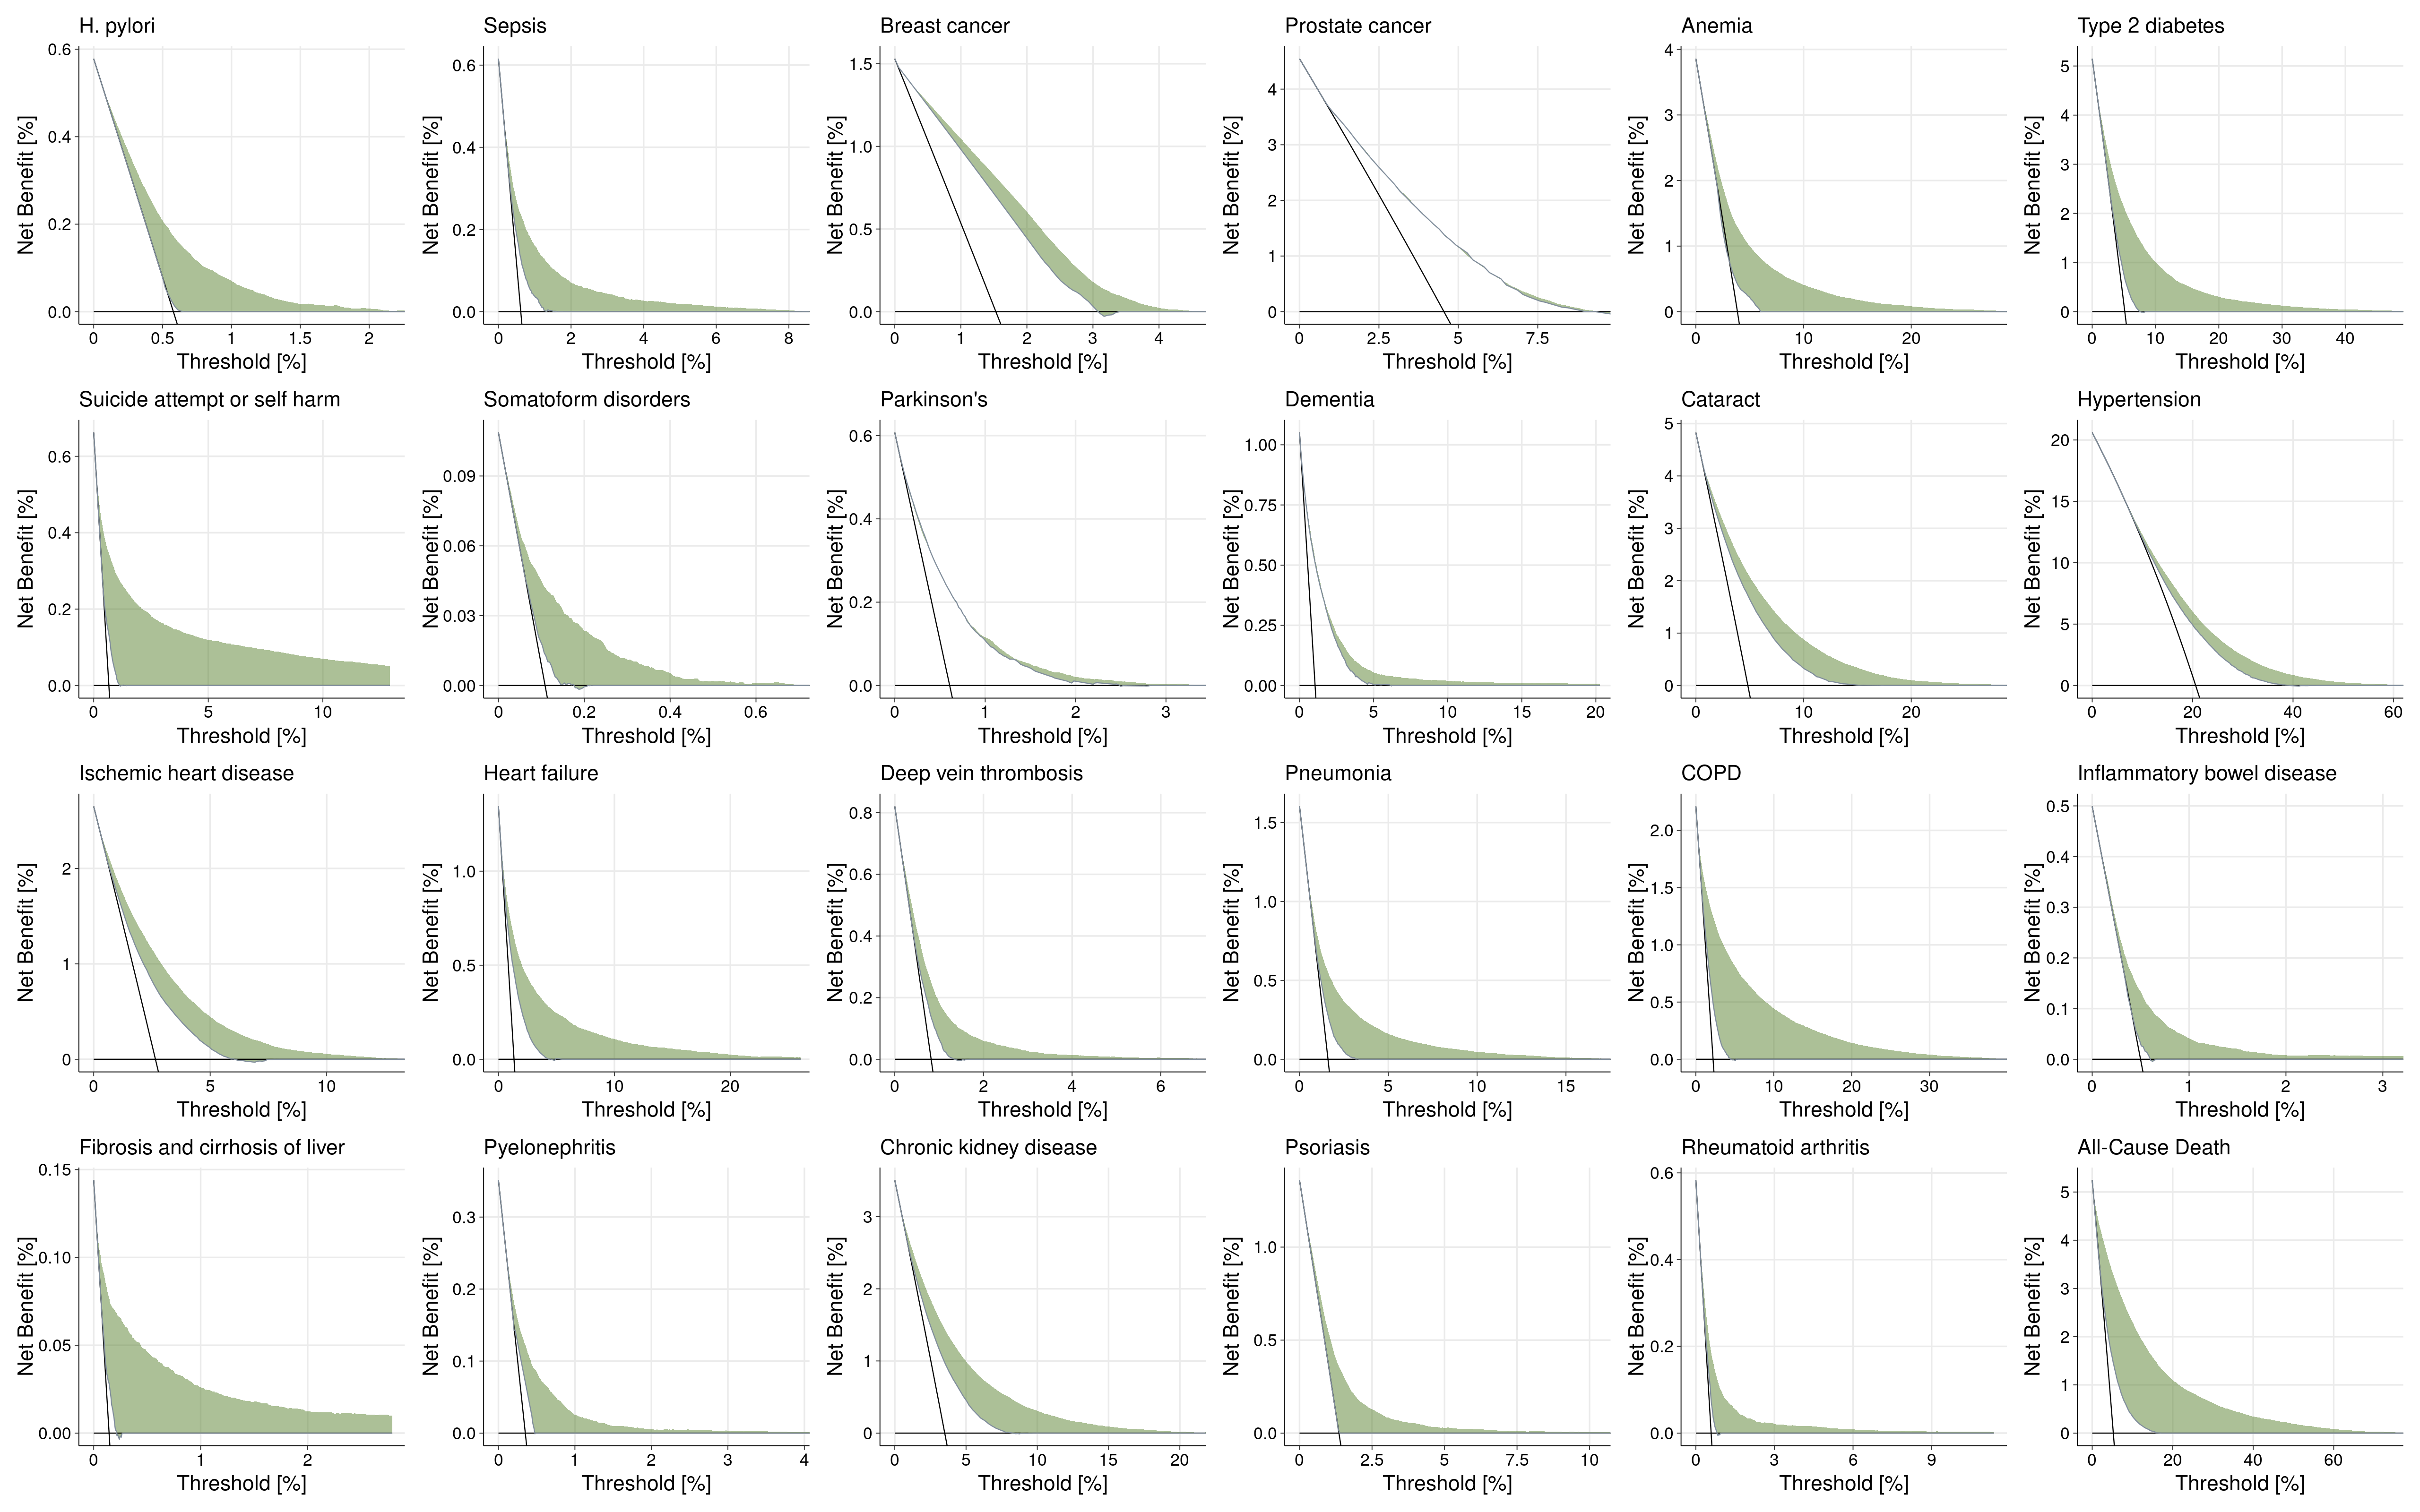

In [132]:
zip <- function(...) {
  mapply(list, ..., SIMPLIFY = TRUE)
}
fig5_dca = wrap_plots(plotsA, ncol=6)
plot_width=16; plot_height=10; plot_dpi=320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_dpi)
fig5_dca

In [ ]:
fig5 = (fig5_cal / fig5_dca) +  plot_layout(height = c(1, 2.5)) & theme(plot.title = element_text(hjust = 0.5))
plot_width=8.25; plot_height=9; plot_dpi=320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_dpi)
fig5

In [ ]:
library(gt)
plot_name = "Figures_5_ABC_ClinicalUtility"
fig5 %>% ggsave(filename=glue("outputs/{plot_name}.pdf"), device="pdf", width=plot_width, height=plot_height, dpi=plot_dpi)

In [ ]:
library(gt)
plot_name = "Figures_5_ABC_ClinicalUtility"
fig5 %>% ggsave(filename=glue("outputs/{plot_name}.png"), device="png", width=plot_width, height=plot_height, dpi=plot_dpi)